# Uplift Regression Discontinuity Analysis


## 5th May 2022 

Original analysis by Aditya Ravuri at suggestion of Bernhard Schoelkopf with hints by Kun Zhang. Applied to the data by Neil. 

How does an accept decision affect the number of citations of a paper?

## Data

Papers with raw scores $S$ above 6.2 are likely to be accepted:
$$ A | S \sim \text{Bernoulli}(\sigma((S-6.2)*5.3))$$

Assume the data generating mechanism for $lC \equiv \log_{10}(1 + \text{citations})$ given an acceptance $A$.
$$ lC | \not A \sim \mathcal N(a(S-6.2) + b, 1) $$
$$ lC | A \sim \mathcal N(b + u, 1) $$
... with $u > 0$.

The assumption we make is that reviewers are able to identify bad papers (hence a positive association between scores and citations) but cannot rank high quality papers in terms of citations that paper is likely to obtain (hence no association between scores and citations given an accepted paper).

Note that if $u=0$, correlations between $lC|\not A$ and $lC$ are unlikely to be very different, and we wouldn't expect the correlation between groups to be higher than the correlation within $lC|\not A$.

The fact that we see a correlation of 0.38 between groups and 0.22 within $lC|\not A$ is indicative of $u>0$ in our data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-pastel')


Some code for simulated data generation.

In [2]:
def generate_scores(n):
    # mixture of normals based on empirical hist
    mu = [2.5, 3, 4, 5, 6, 7, 7.5, 8.25]
    p = [0.03, 0.12, 0.22, 0.20, 0.19, 0.16, 0.05, 0.03]
    covar = np.eye(len(mu)) * 1/4**2
    norms = np.random.multivariate_normal(mu, covar, n)
    comps = np.random.choice(len(mu), n, p=p)
    return norms[np.arange(n), comps]

def accept_p(score):
    return 1 / (1 + np.exp((6.2 - score)*5.3))  # from torch optim

def lC(a=0.24, b=2, u=0.34):  # from PSO
    np.random.seed(42)
    lC = np.zeros(n)
    lC[accepts == 0] = np.random.normal((scores[accepts == 0] - 6.2)*a + b, 1)
    lC[accepts == 1] = np.random.normal(b + u, 1, sum(accepts))
    return lC



In [ ]:
np.random.seed(42)
n = 1000
simulate_data = False

In [45]:
if simulate_data:
    scores = generate_scores(n)
    accepts = np.random.binomial(1, accept_p(scores))
    log_citations = lC()
     
    # Check correlation between groups:
    print(np.corrcoef(scores, lC())[0, 1].round(2))
    print(np.corrcoef(scores[accepts == 0], lC()[accepts == 0])[0, 1].round(2))
else:
    import cmtutils as cu
    import cmtutils.nipsy as nipsy
    decisions = nipsy.load_decisions()
    decisions = decisions.loc[decisions.index!='nan']
    date = "2021-06-11"
    citations = nipsy.load_citation_counts(date=date)
    nipsy.augment_decisions(decisions)
    joindf = nipsy.join_decisions_citations(decisions, citations)

    log_citations = np.log10(1+joindf['numCitedBy'])
    accepts = joindf.accept
    scores = joindf.average_calibrated_quality

Check correlation between groups:

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


Text(0.5, 1.0, 'Score vs Citations')

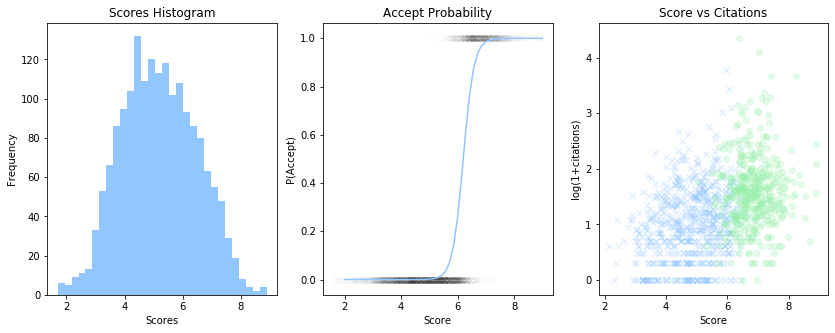

In [46]:
fig, (ax_a, ax_b, ax_c) = plt.subplots(1, 3, figsize=(14, 5))

ax_a.hist(scores, bins=30)
ax_a.set_title('Scores Histogram')
ax_a.set_xlabel('Scores')
ax_a.set_ylabel('Frequency')

ax_b.plot(np.linspace(2, 9), accept_p(np.linspace(2, 9)))
ax_b.scatter(scores, accepts, marker='x', alpha=0.01, c='black')
ax_b.set_title('Accept Probability')
ax_b.set_xlabel('Score')
ax_b.set_ylabel('P(Accept)')

ax_c.scatter(scores[accepts == 0], log_citations[accepts == 0], marker='x', label='reg', alpha=0.25)
ax_c.scatter(scores[accepts == 1], log_citations[accepts == 1], label='accp', alpha=0.25)
ax_c.set_xlabel('Score')
ax_c.set_ylabel('log(1+citations)')
ax_c.set_title('Score vs Citations')

## Causal effect identification using dowhy

In [47]:
%pip install --upgrade dowhy

Note: you may need to restart the kernel to use updated packages.


In [40]:
%%capture
import pandas as pd
import dowhy
from dowhy import CausalModel

df = pd.DataFrame({'accepts': accepts, 'scores': scores, 'log_citations': log_citations})
df = df.dropna()
graph = 'digraph{ accepts -> log_citations   scores -> accepts}'

model = CausalModel(
    data = df,
    treatment='accepts',
    outcome='log_citations',
    graph=graph,
    instruments='performance_previous'
)

identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

estimate = model.estimate_effect(identified_estimand,
    method_name='iv.regression_discontinuity',
    method_params={'rd_variable_name': 'scores',
                   'rd_threshold_value': 6.2,
                   'rd_bandwidth': 0.4}
)

In [41]:
%%capture
conf_interval = estimate.get_confidence_intervals()

In [42]:
print(estimate.value)
conf_interval

0.47940423027002954
